## Projeto - Série Temporal do Preço da Soja

A soja é um dos principais itens da agropecuária brasileira, com grande importância na pauta exportadora brasileira. Em 2022 a exportação da soja gerou mais de 46 bilhões dólares para o país, ficando em primeiro lugar entre os produtos com maior valor de exportação no ano. Esse excelente resultado tem dois componentes: preço e quantidade. Foram exportadas mais de 78 milhões de toneladas em 2022, colocando o Brasil como um dos maiores exportadores de soja do mundo ao lado dos Estados Unidos. Outro componente é o preço, que registra uma alta nos preços internacionais desde 2020, sendo que em 2022 a alta é de cerca de 12%. 

Percebe-se a importância da soja para o país e para o mundo. Não é para menos, a soja é uma das principais fontes de alimentos do mundo. Está no óleo vegetal, em suplementos de proteínas, é fonte de alimentos para pessoas que não comem produtos de origem animal e o seu uso se estende para usos além da alimentação. A soja, portanto, está no dia a dia de grande parte da população animal.

Diante desse cenário, pode ser de grande importância prever o comportamento dos preços da soja para alguns setores. Com esse objetivo que este projeto é realizado. Faremos a investigação da série de preços da saca de 60kg da soja, série que pode ser encontrada em https://www.cepea.esalq.usp.br/br/indicador/soja.aspx. Além disso, aplicaremos técnicas de séries temporais para avaliar a possibilidade da previsão dos preços dessa série.

<img src='soja.jpg'>

In [1]:
# Manipulação dos Dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística
import statsmodels.api as sm
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Prophet
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

#### Importando Modulos

In [2]:
# Funcoes
from Modulos.FUNCAO_Limpa_Dados import limpando_dados
from Modulos.FUNCAO_Media_Movel import calculo_media_movel
from Modulos.FUNCAO_Corrigindo_Inflacao import corrigindo_inflacao
from Modulos.FUNCAO_Avaliando_Modelos import AvaliandoModelos
from Modulos.FUNCAO_Retomando_Valores_Previsao import retomando_valor_previsto, recuperando_valores_MM5
from Modulos.FUNCAO_Lineplot import lineplot

# Classes
from Modulos.CLASSE_Teste_Dickey_Fuller import DickeyFuller
from Modulos.CLASSE_Acumulando_Inflacao_Diaria import AcumulandoInflacaoDiaria
from Modulos.CLASSE_Plot_Erro import PlotResiduos

In [3]:
# Carregando os dados
df = pd.read_excel('preco_soja.xls')

# Aplica função que limpa os dados
df = limpando_dados(df)

# Olhando primeiros resultados
df.head(4)

,preco_reais
data,
2016-01-04,81.64
2016-01-05,82.26
2016-01-06,81.84
2016-01-07,82.35


#### Visualizando a série

Nossa série começa em janeiro de 2016 e termina em dezembro de 2019. Evitamos o período posterior por conta da pandemia de COVID-19 que pode trazer eventos excessivamente incomuns incompatíveis com a série temporal no período anterior. Percebemos que há uma movimentação de alta nos preços sempre no primeiro semestre do ano seguido de uma queda no segundo semestre até o fim do ano. O ano de 2018 talvez foge um pouco desse padrão quando o aumento de preços seguiu ainda no início do segundo semestre, embora a queda no fim do ano tenha sido registrada.

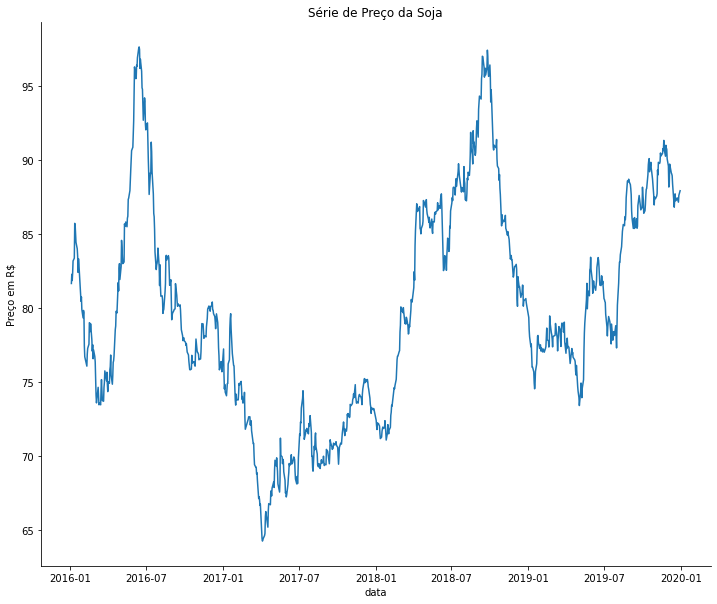

In [4]:
lineplot(df.index, df['preco_reais'], 'Série de Preço da Soja', 'Preço em R$')

#### Visualizando a média móvel de 5 dias

A média móvel de 5 dias consegue capturar bem as movimentações de preços diárias. Posteriormente treinaremos um modelo de médias móveis para realizar previsões para ver o seu desempenho. Abaixo temos os intervalos de confiança para 95% de significância. A linha azul é a linha com a série de preços original, enquanto as linhas verde e laranja são o limite superior e inferior do intervalo de confiança para a média móvel de 5 dias, respectivamente. Podemos ver que praticamente em toda a série o preço fica dentro do intervalo de confiança.

In [5]:
media_movel_5dias = calculo_media_movel(df, 'preco_reais', 5)

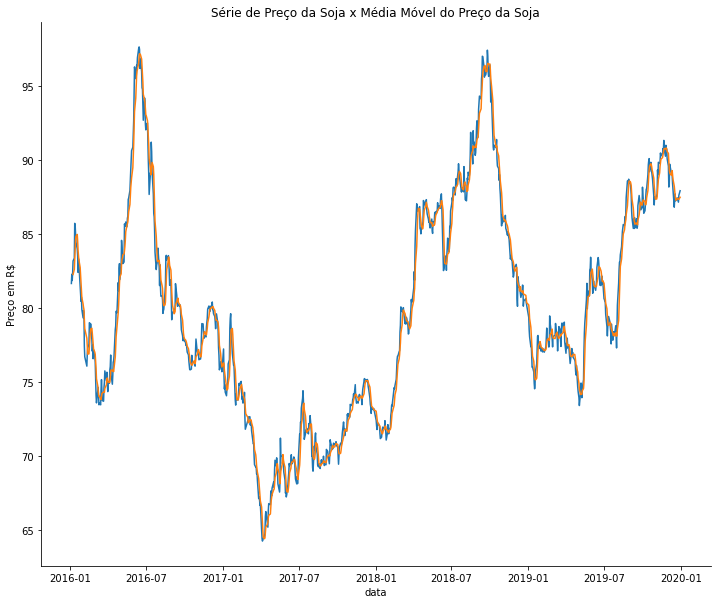

In [6]:
lineplot(df.index, df['preco_reais'], 'Série de Preço da Soja x Média Móvel do Preço da Soja', 'Preço em R$',
         media_movel_5dias.index, media_movel_5dias.media_movel)

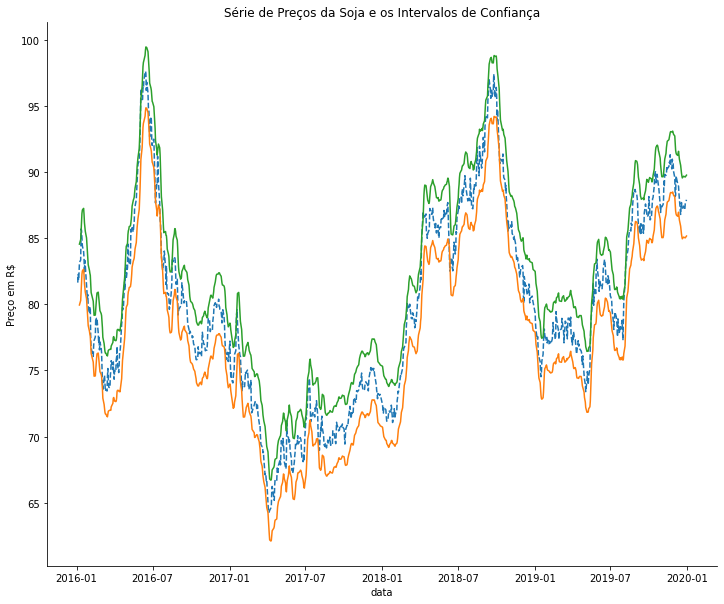

In [7]:
fig, ax = plt.subplots(figsize = (12, 10))

sns.lineplot(df.index, df['preco_reais'], linestyle = "dashed")
sns.lineplot(media_movel_5dias.index, media_movel_5dias['mm_limite_abaixo'])
sns.lineplot(media_movel_5dias.index, media_movel_5dias['mm_limite_acima'])

ax.set_title('Série de Preços da Soja e os Intervalos de Confiança')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Preço em R$')
plt.show()

plt.show();

#### Dividindo entre dados de treino e teste

75% dos dados serão destinados a treino e 25% dos dados serão destinados a teste.
* 748 observações
* 249 observações

In [8]:
treino = df.iloc[:749, :]
teste = df.iloc[749:, :]

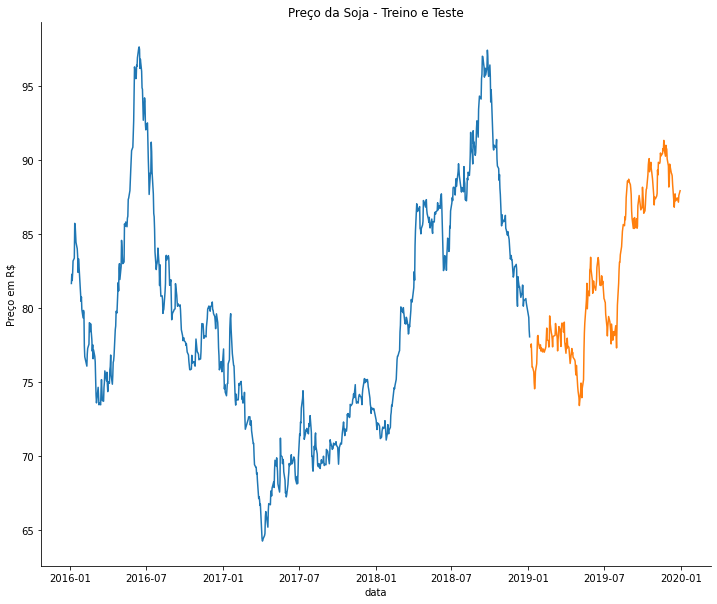

In [9]:
lineplot(treino.index, treino['preco_reais'], 'Preço da Soja - Treino e Teste',
        'Preço em R$', teste.index, teste['preco_reais'])

#### Avaliando Sazonalidade e Tendência

Os dados de treino apresentam duas tendências de alta e conseguimos observar a sazonalidade presente. Os resíduos parecem se encontrar em torno de 0.

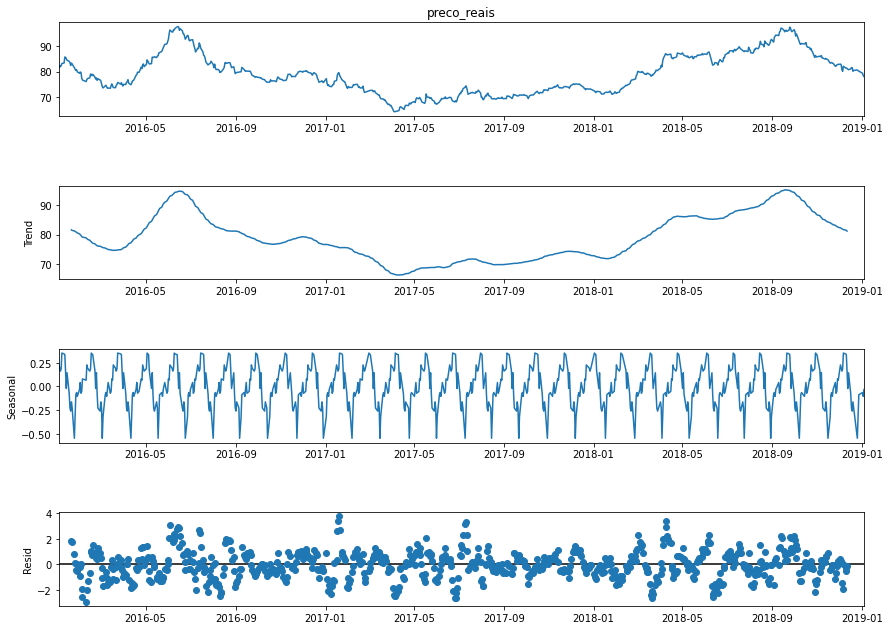

In [10]:
sazonalidade_trend = seasonal_decompose(treino['preco_reais'], period = 26)
sazo_graph = sazonalidade_trend.plot()
sazo_graph.set_size_inches(14, 10);

#### Testando Estacionariedade (Dickey-Fuller)

O teste de Dickey-Fuller é útil para avaliarmos se uma série temporal é estacionária. Estacionariedade é uma das condições necessárias, porém não suficiente, para realizarmos previsões com uma série de modelos de séries temporais. Uma série estacionária tem média e variância que não mudam ao longo do tempo. O teste tem as seguintes hipóteses:
* Ho: A série não é estacionária.
* Ha: A série é estacionária.

Quando não temos uma série estacionária, é conveniente realizar a primeira diferença da série - subtrair o valor em t+1 do valor em t - e realizar novamente o teste de Dickey-Fuller. A primeira diferença costuma ser o suficiente para tornar a série estacionária, embora em alguns casos mais de uma diferenciação precise ser feita.

Neste projeto o resultado do teste de Dickey-Fuller na série original falha em rejeitar a hipótese nula. Portanto, não temos evidências de estacionariedade na série. Após tomar a primeira diferença, realizamos novamente o teste e encontramos evidências de estacionariedade.

In [11]:
Teste_DF = DickeyFuller(treino['preco_reais'])
Teste_DF.resultados_teste()

Resultados do teste de Dickey-Fuller!
----------------------------------------------------------------------
Valor Dickey-Fuller: -1.4609
p-valor: 0.5528
Lags: 1
Observações: 747
----------------------------------------------------------------------
O valor crítico para um nível de significância de 1% é: -3.4391
O valor crítico para um nível de significância de 5% é: -2.8654
O valor crítico para um nível de significância de 10% é: -2.5688


'Falhamos em rejeitar a hipótese nula! Sem evidência de estacionariedade!'

#### Tornando a série estacionária

Vamos diferenciar a série em um período. Esse é um processo famoso por conseguir tornar uma serié estacionária.

In [12]:
treino_diferenciado = treino.diff().dropna()
teste_diferenciado = teste.diff().dropna()

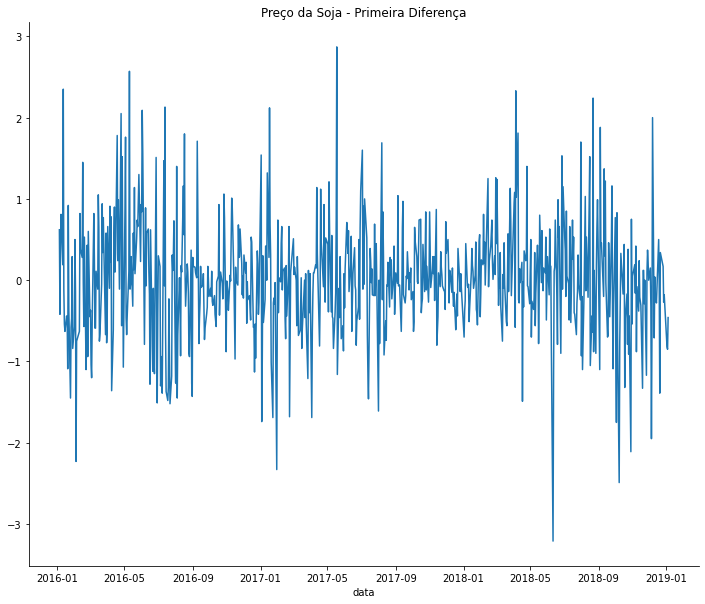

In [13]:
lineplot(treino_diferenciado.index, treino_diferenciado['preco_reais'],
        'Preço da Soja - Primeira Diferença')

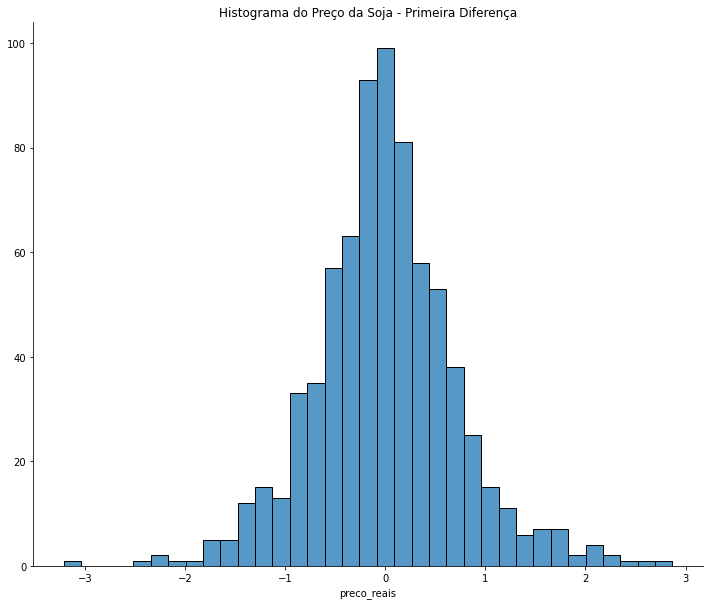

In [14]:
fig, ax = plt.subplots(figsize = (12, 10))

sns.histplot(treino_diferenciado['preco_reais'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Histograma do Preço da Soja - Primeira Diferença')
plt.ylabel('')
plt.show();

In [15]:
Teste_DF_diff = DickeyFuller(treino_diferenciado['preco_reais'])
Teste_DF_diff.resultados_teste()

Resultados do teste de Dickey-Fuller!
----------------------------------------------------------------------
Valor Dickey-Fuller: -24.0266
p-valor: 0.0
Lags: 0
Observações: 747
----------------------------------------------------------------------
O valor crítico para um nível de significância de 1% é: -3.4391
O valor crítico para um nível de significância de 5% é: -2.8654
O valor crítico para um nível de significância de 10% é: -2.5688


'Rejeitamos a hipótese nula! Evidência de estacionariedade!'

#### Ajustando pela inflação

Também podemos conseguir tornar a série estacionária ao reajustar pela inflação. Como temos valores de preços diários e o índice do IPCA é mensal, precisamos acumular a inflação para taxas diárias e depois aplicar a correção de preços na série original.

Finalizado o processo de correção de preços, observamos no gráfico que os preços estão corrigidos para níveis de novembro de 2019. Como tivemos inflação no período - ou seja, aumento no nível de preços -, valores corrigidos de 2016 são menores do que os verificados na série original. No dia 04 de janeiro de 2016, por exemplo, a série original apresenta um preço de R\\$81,64, que equivale a R\\$74,90 em níveis de 2019.

Realizamos novamente os testes de Dickey-Fuller e falhamos em rejeitar a hipótese nula. Em outras palavras, corrigir a série original pela inflação não tornou a série estacionária e, portanto, a série corrigida não será útil para realizar previsões.

In [16]:
Inflacao_Diaria = AcumulandoInflacaoDiaria(indice = 'ipca', numero_serie = 433, inicio = '2016-01-01', fim = '2019-12-31')
df_inflacao_diaria = Inflacao_Diaria.convertendo_inflacao_mensal_para_diaria()

In [17]:
# Aplicando a correção dos preços
treino = corrigindo_inflacao(treino, df_inflacao_diaria)

# Visualizando valores corrigidos e não corrigidos
treino.head(6)

,preco_reais,preco_corrigido
data,,
2016-01-04,81.64,74.90
2016-01-05,82.26,75.49
2016-01-06,81.84,75.14
2016-01-07,82.35,75.64
2016-01-08,83.16,76.41
2016-01-11,83.35,76.62


#### Visualizando a distribuição dos preços corrigidos

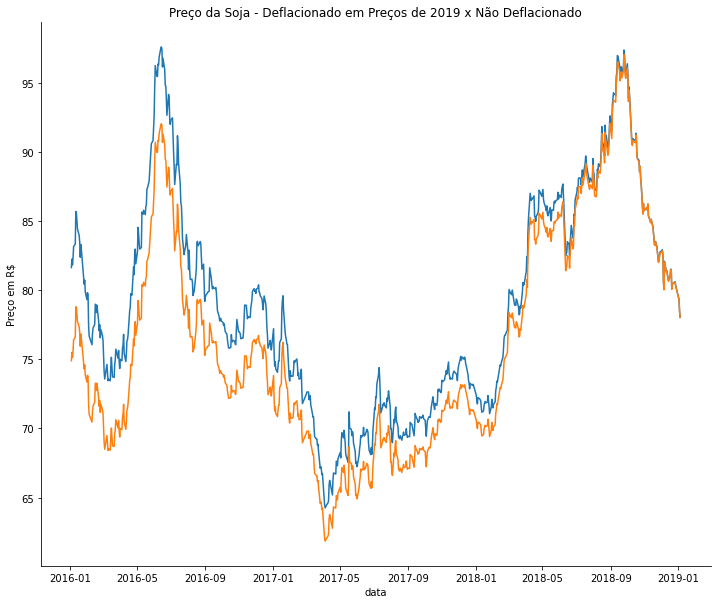

In [18]:
lineplot(treino.index, treino['preco_reais'], 'Preço da Soja - Deflacionado em Preços de 2019 x Não Deflacionado',
        'Preço em R$', treino.index, treino['preco_corrigido'])

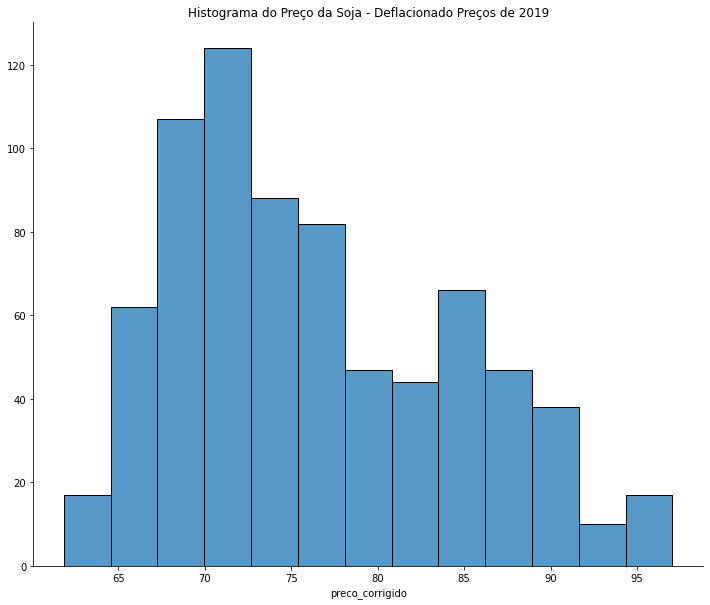

In [19]:
fig, ax = plt.subplots(figsize = (12, 10))

sns.histplot(treino['preco_corrigido'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Histograma do Preço da Soja - Deflacionado Preços de 2019')
plt.ylabel('')
plt.show();

In [20]:
Teste_DF_inflacao = DickeyFuller(treino['preco_corrigido'])
Teste_DF_inflacao.resultados_teste()

Resultados do teste de Dickey-Fuller!
----------------------------------------------------------------------
Valor Dickey-Fuller: -1.3184
p-valor: 0.6207
Lags: 1
Observações: 747
----------------------------------------------------------------------
O valor crítico para um nível de significância de 1% é: -3.4391
O valor crítico para um nível de significância de 5% é: -2.8654
O valor crítico para um nível de significância de 10% é: -2.5688


'Falhamos em rejeitar a hipótese nula! Sem evidência de estacionariedade!'

#### Avaliando a autocorrelação nas séries não estacionárias e estacionárias

Os gráficos de autocorrelação (ACF) e autocorrelação parcial (PACF) são úteis para identificar se a série possui autocorrelação. Uma série que tem seu preço no período t dependendente do preço no período t-1 apresenta um lag correlacionado de 1 período.

Esses gráficos nos ajudam na tarefa de escolher qual o modelo de séries temporais é o mais apropriado para realizar o treinamento e posterior previsão da série.

Plotamos os gráficos ACF e PACF nos dados da série diferenciada. No ACF encontramos apenas um lag significativo, sendo que há um forte decaimento dos outros lags para a não significância. No PACF temos o mesmo comportamento. Quando temos 

#### Série Estacionária

Temos evidência de lags autocorrelacionados de primeira ordem. Gráficos típicos de um processo ARMA (1, 1) dado que a primeiro lag é correlacionado e depois a correlação cai bruscamente tanto em ACF quanto em PACF. Esses gráficos são típicos de um processo AR(1). Realizamos um treinamento desse modelo e previsão para ver os seus resultados.

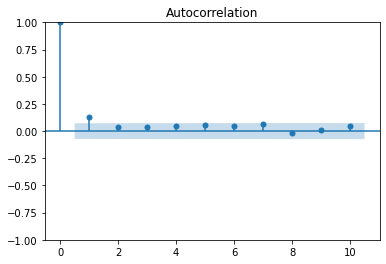

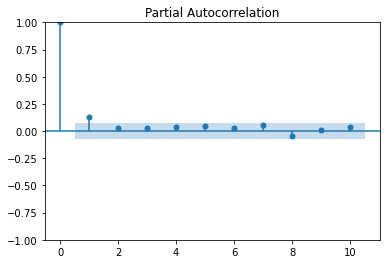

In [21]:
plot_acf(treino_diferenciado['preco_reais'], lags = 10);
plot_pacf(treino_diferenciado['preco_reais'], lags = 10);

### Previsões

A partir de agora iremos realizar a estimação de quatro modelos:
* Média Móvel de 5 dias.
* Média Móvel Exponencial
* ARIMA(1, 1, 0)
* ARIMA(1, 1, 1)

### Modelo 1 - Média Móvel de 5 dias

#### Avaliando em Treino

In [22]:
modeloV1_MM_treino = treino_diferenciado[['preco_reais']]
modeloV1_MM_treino.columns = ['Observado']
modeloV1_MM_treino['Previsto'] = modeloV1_MM_treino.rolling(5).mean()
modeloV1_MM_treino.dropna(inplace = True)

In [23]:
modeloV1_avalia_treino = recuperando_valores_MM5(treino['preco_reais'], modeloV1_MM_treino['Previsto'], treino = True)

avaliacao_treino = AvaliandoModelos(modeloV1_avalia_treino['Preco_Original'],
                                    modeloV1_avalia_treino['Preco_Previsto'], 
                                    nome_col = 'ModeloV1_MM_5Dias', nome_indice = 'Treino')

In [24]:
avaliacao_treino

,ModeloV1_MM_5Dias
Treino,
MSE,0.391708
RMSE,0.625866
MAE,0.472164
MAPE,0.594312


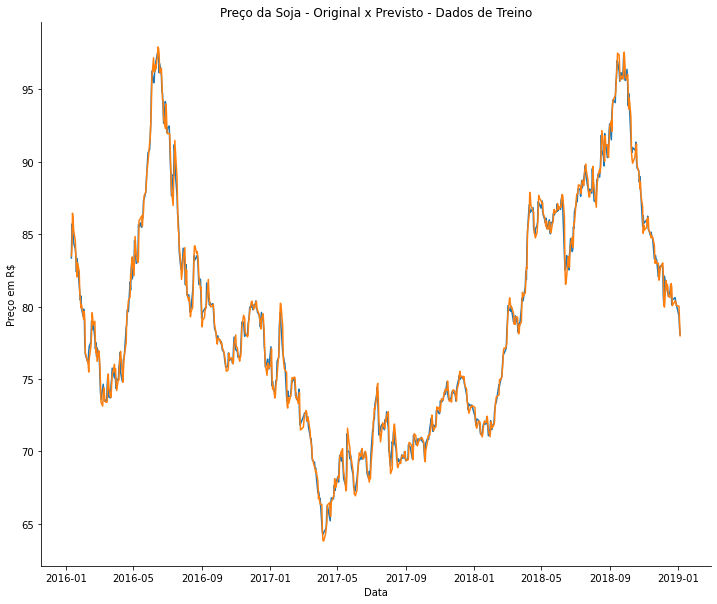

In [25]:
lineplot(modeloV1_avalia_treino.index, modeloV1_avalia_treino['Preco_Original'],
         'Preço da Soja - Original x Previsto - Dados de Treino', 'Preço em R$',
         modeloV1_avalia_treino.index, modeloV1_avalia_treino['Preco_Previsto'])

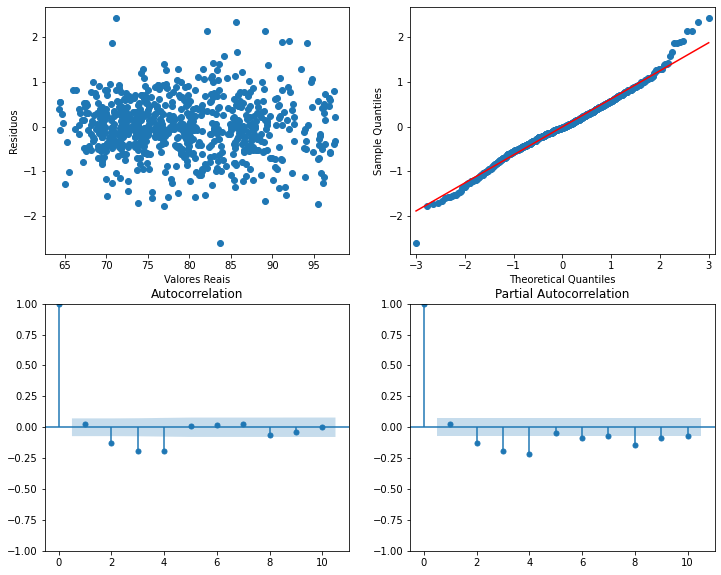

In [26]:
residuosV1_treino = PlotResiduos(modeloV1_avalia_treino)
residuosV1_treino.plot_residuos()

#### Avaliando em Teste

In [27]:
modeloV1_MM_teste = teste_diferenciado[['preco_reais']]
modeloV1_MM_teste.columns = ['Observado']

hist = [modeloV1_MM_treino.iloc[i, 0] for i in range(len(modeloV1_MM_treino))]
lista_previsao = []

for t in range(len(modeloV1_MM_teste)):
    yhat = np.mean(hist[-5:])
    obs = modeloV1_MM_teste.iloc[t, 0]
    lista_previsao.append(yhat)
    hist.append(obs)

modeloV1_MM_teste['Previsto'] = lista_previsao

In [28]:
modeloV1_avalia_teste = recuperando_valores_MM5(teste['preco_reais'], modeloV1_MM_teste['Previsto'], treino = False)

avaliacao_teste = AvaliandoModelos(modeloV1_avalia_teste['Preco_Original'],
                                   modeloV1_avalia_teste['Preco_Previsto'],
                                   nome_col = 'ModeloV1_MM_5Dias', nome_indice = 'Teste')

In [29]:
avaliacao_teste

,ModeloV1_MM_5Dias
Teste,
MSE,0.489598
RMSE,0.699712
MAE,0.548502
MAPE,0.670886


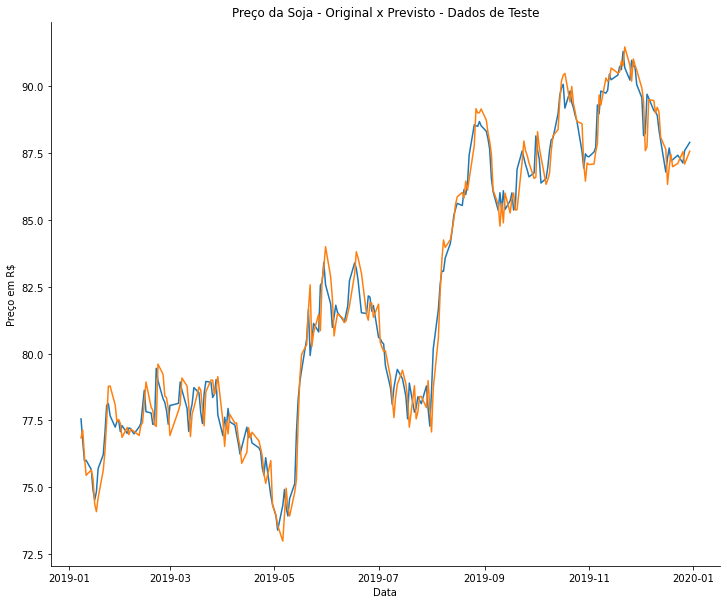

In [30]:
lineplot(modeloV1_avalia_teste.index, modeloV1_avalia_teste['Preco_Original'],
        'Preço da Soja - Original x Previsto - Dados de Teste', 'Preço em R$',
        modeloV1_avalia_teste.index, modeloV1_avalia_teste['Preco_Previsto'])

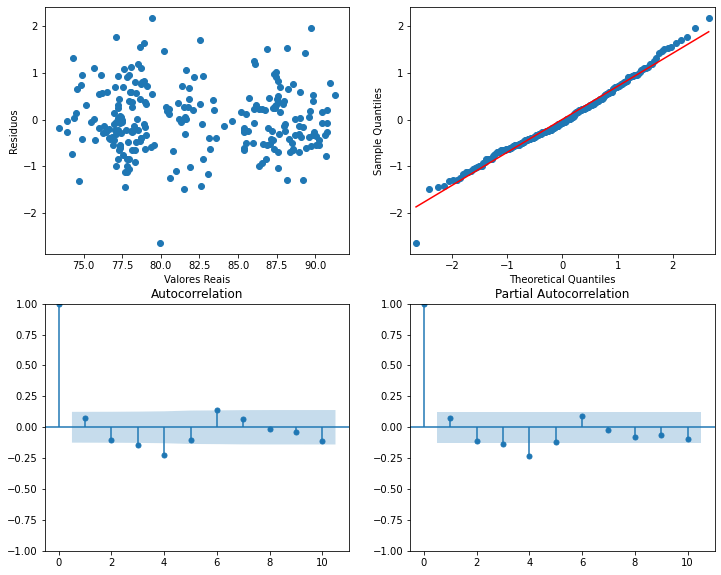

In [31]:
residuosV1_teste = PlotResiduos(modeloV1_avalia_teste)
residuosV1_teste.plot_residuos()

### Modelo 2 - Média Móvel Exponencial

#### Avaliando em treino

In [32]:
modeloV2_MME_treino = treino_diferenciado[['preco_reais']]
modeloV2_MME_treino.columns = ['Observado']

alpha = 0.1
modelo_v2 = ExponentialSmoothing(modeloV2_MME_treino['Observado']).fit(smoothing_level = alpha)
modeloV2_MME_treino['Previsto'] = modelo_v2.predict(start = 0, end = len(modeloV2_MME_treino) - 1)

In [33]:
modeloV2_avalia_treino = retomando_valor_previsto(treino['preco_reais'], modeloV2_MME_treino['Previsto'])

avaliacao_treino['ModeloV2_MME'] = AvaliandoModelos(modeloV2_avalia_treino['Preco_Original'],
                                                    modeloV2_avalia_treino['Preco_Previsto'])

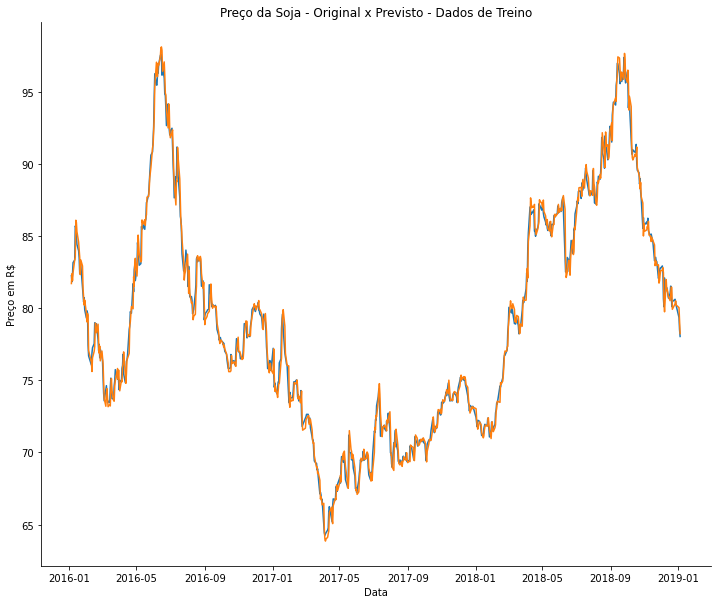

In [34]:
lineplot(modeloV2_avalia_treino.index, modeloV2_avalia_treino['Preco_Original'],
         'Preço da Soja - Original x Previsto - Dados de Treino', 'Preço em R$',
        modeloV2_avalia_treino.index, modeloV2_avalia_treino['Preco_Previsto'])

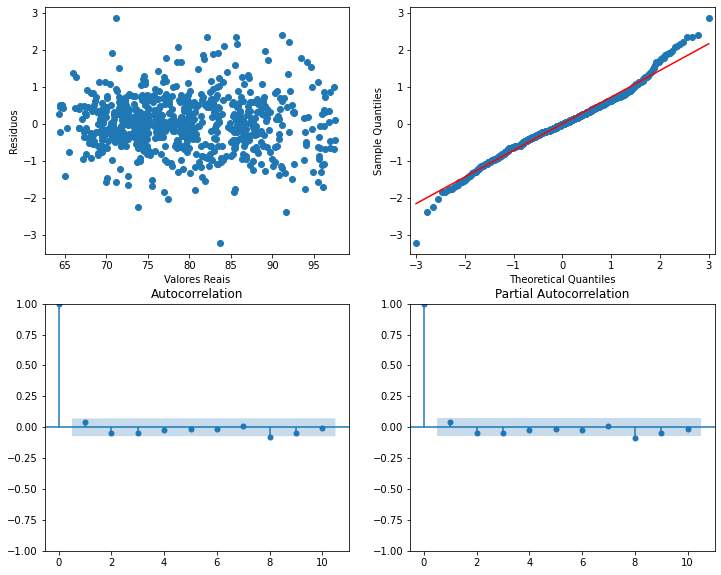

In [35]:
residuosV2_treino = PlotResiduos(modeloV2_avalia_treino)
residuosV2_treino.plot_residuos()

In [36]:
modelo_v2.summary()

Dep. Variable:,Observado,No. Observations:,748
Model:,ExponentialSmoothing,SSE,387.940
Optimized:,True,AIC,-487.102
Trend:,None,BIC,-477.867
Seasonal:,None,AICC,-487.048
Seasonal Periods:,None,Date:,"Thu, 09 Feb 2023"
Box-Cox:,False,Time:,13:11:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
initial_level,0.0732544,l.0,True


#### Avaliando em teste

In [37]:
modeloV2_MME_teste = teste_diferenciado[['preco_reais']]
modeloV2_MME_teste.columns = ['Observado']

hist = [modeloV2_MME_treino.iloc[i, 0] for i in range(len(modeloV2_MME_treino))]
hist_prev = [modeloV2_MME_treino.iloc[i, 1] for i in range(len(modeloV2_MME_treino))]
lista_previsao = []

for t in range(len(modeloV2_MME_teste)):
    yhat = hist_prev[-1] + (alpha * (hist[-1] - hist_prev[-1]))
    obs = modeloV2_MME_teste.iloc[t, 0]
    lista_previsao.append(yhat)
    hist.append(obs)
    hist_prev.append(yhat)

modeloV2_MME_teste['Previsto'] = lista_previsao

In [38]:
modeloV2_avalia_teste = retomando_valor_previsto(teste['preco_reais'], modeloV2_MME_teste['Previsto'])

avaliacao_teste['ModeloV2_MME'] = AvaliandoModelos(modeloV2_avalia_teste['Preco_Original'],
                                                   modeloV2_avalia_teste['Preco_Previsto'])

In [39]:
avaliacao_teste

,ModeloV1_MM_5Dias,ModeloV2_MME
Teste,,
MSE,0.489598,0.434751
RMSE,0.699712,0.659357
MAE,0.548502,0.522348
MAPE,0.670886,0.638658


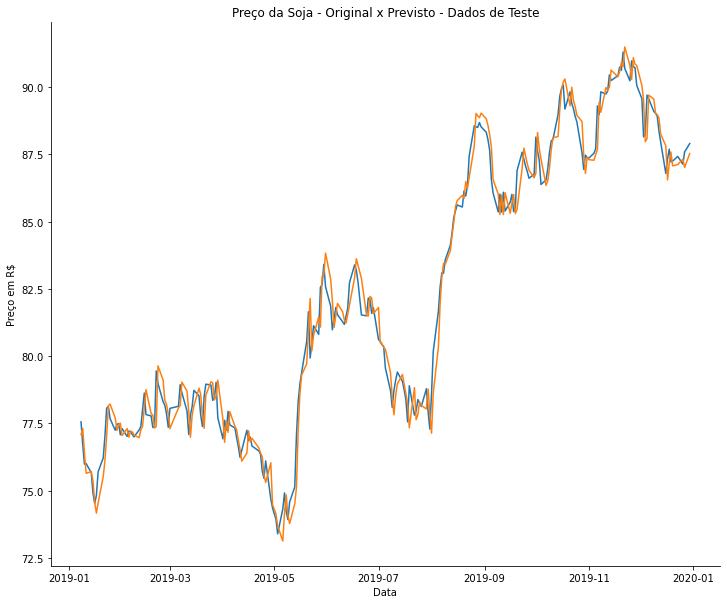

In [40]:
lineplot(modeloV2_avalia_teste.index, modeloV2_avalia_teste['Preco_Original'],
         'Preço da Soja - Original x Previsto - Dados de Teste', 'Preço em R$',
        modeloV2_avalia_teste.index, modeloV2_avalia_teste['Preco_Previsto'])

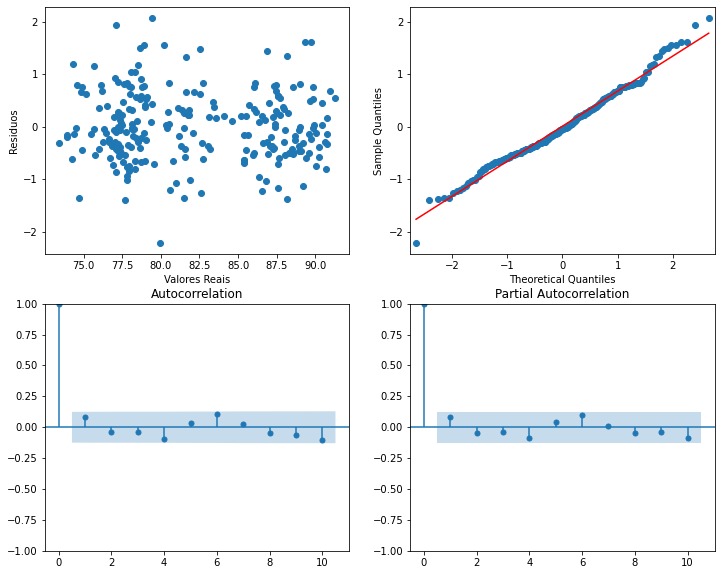

In [41]:
residuosV2_teste = PlotResiduos(modeloV2_avalia_teste)
residuosV2_teste.plot_residuos()

### Modelo 3 - AR(1)

#### Avaliando em treino

In [42]:
modeloV3_AR1_treino = treino_diferenciado[['preco_reais']]
modeloV3_AR1_treino.columns = ['Observado']

modelo_v3 = ARIMA(modeloV3_AR1_treino['Observado'], order = [1, 0, 0]).fit()
modeloV3_AR1_treino['Previsto'] = modelo_v3.predict(start = 0, end = len(modeloV3_AR1_treino) - 1)

In [43]:
modeloV3_avalia_treino = retomando_valor_previsto(treino['preco_reais'], modeloV3_AR1_treino['Previsto'])

avaliacao_treino['ModeloV3_AR1'] = AvaliandoModelos(modeloV3_avalia_treino['Preco_Original'],
                                                    modeloV3_avalia_treino['Preco_Previsto'])

In [44]:
avaliacao_treino

,ModeloV1_MM_5Dias,ModeloV2_MME,ModeloV3_AR1
Treino,,,
MSE,0.391708,0.518593,0.506191
RMSE,0.625866,0.720134,0.711471
MAE,0.472164,0.540521,0.524773
MAPE,0.594312,0.678869,0.658227


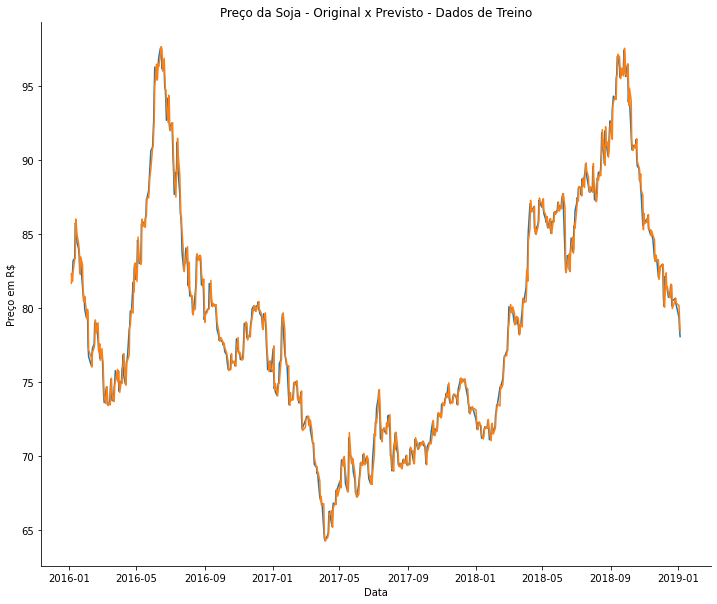

In [45]:
lineplot(modeloV3_avalia_treino.index, modeloV3_avalia_treino['Preco_Original'],
         'Preço da Soja - Original x Previsto - Dados de Treino', 'Preço em R$',
        modeloV3_avalia_treino.index, modeloV3_avalia_treino['Preco_Previsto'])

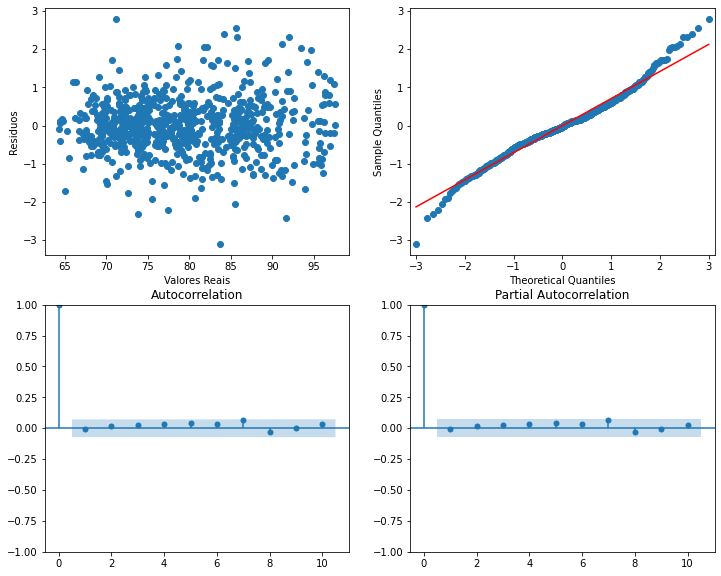

In [46]:
residuosV3_treino = PlotResiduos(modeloV3_avalia_treino)
residuosV3_treino.plot_residuos()

In [47]:
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Observado   No. Observations:                  748
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -806.874
Date:                Thu, 09 Feb 2023   AIC                           1619.748
Time:                        13:11:40   BIC                           1633.600
Sample:                             0   HQIC                          1625.086
                                - 748                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.030     -0.160      0.873      -0.063       0.054
ar.L1          0.1271      0.033      3.814      0.000       0.062       0.192
sigma2         0.5064      0.019     26.001      0.000       0.468       0.545
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                89.69
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.18
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Avaliando em teste

In [48]:
modeloV3_AR1_teste = teste_diferenciado[['preco_reais']]
modeloV3_AR1_teste.columns = ['Observado']

coef_ar1 = modelo_v3.arparams.item()
hist = [modeloV3_AR1_treino.iloc[i, 0] for i in range(len(modeloV3_AR1_treino))]
lista_previsao = []

for t in range(len(modeloV3_AR1_teste)):
    yhat = (hist[-1] * coef_ar1)
    obs = modeloV3_AR1_teste.iloc[t, 0]
    lista_previsao.append(yhat)
    hist.append(obs)

modeloV3_AR1_teste['Previsto'] = lista_previsao

In [49]:
modeloV3_avalia_teste = retomando_valor_previsto(teste['preco_reais'], modeloV3_AR1_teste['Previsto'])

avaliacao_teste['ModeloV3_AR1'] = AvaliandoModelos(modeloV3_avalia_teste['Preco_Original'],
                                                   modeloV3_avalia_teste['Preco_Previsto'])

In [50]:
avaliacao_teste

,ModeloV1_MM_5Dias,ModeloV2_MME,ModeloV3_AR1
Teste,,,
MSE,0.489598,0.434751,0.411132
RMSE,0.699712,0.659357,0.641195
MAE,0.548502,0.522348,0.511781
MAPE,0.670886,0.638658,0.626352


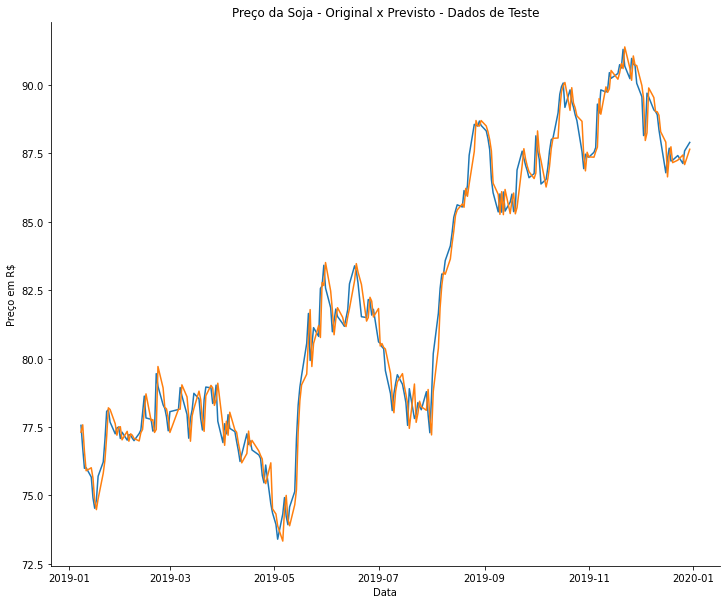

In [51]:
lineplot(modeloV3_avalia_teste.index, modeloV3_avalia_teste['Preco_Original'],
         'Preço da Soja - Original x Previsto - Dados de Teste', 'Preço em R$',
        modeloV3_avalia_teste.index, modeloV3_avalia_teste['Preco_Previsto'])

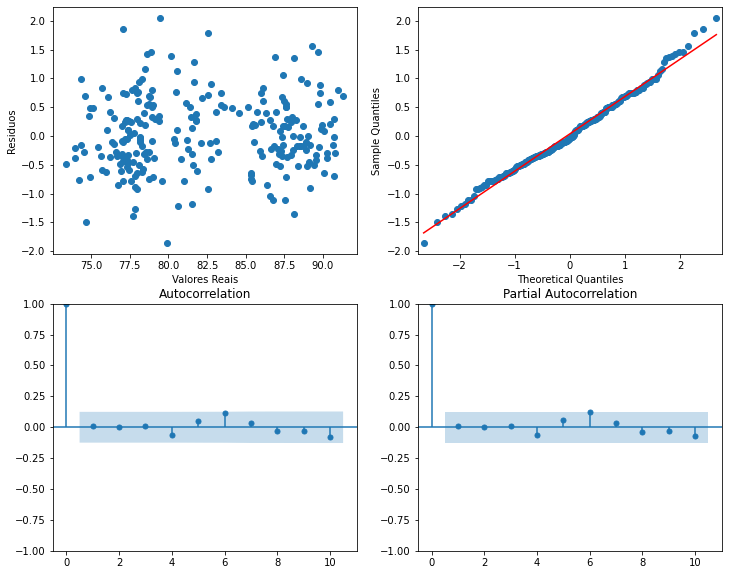

In [52]:
residuosV3_teste = PlotResiduos(modeloV3_avalia_teste)
residuosV3_teste.plot_residuos()

### Modelo 4 - ARIMA (1, 1, 1)

#### Avaliando em treino

In [53]:
modeloV4_ARMA_treino = treino_diferenciado[['preco_reais']]
modeloV4_ARMA_treino.columns = ['Observado']

modelo_v4 = ARIMA(modeloV4_ARMA_treino['Observado'], order = (1, 0, 1)).fit()
modeloV4_ARMA_treino['Previsto'] = modelo_v4.predict(start = 0, end = len(modeloV4_ARMA_treino) - 1)

In [54]:
modeloV4_avalia_treino = retomando_valor_previsto(treino['preco_reais'], modeloV4_ARMA_treino['Previsto'])

avaliacao_treino['ModeloV4_ARIMA11'] = AvaliandoModelos(modeloV4_avalia_treino['Preco_Original'],
                                                       modeloV4_avalia_treino['Preco_Previsto'])

In [55]:
avaliacao_treino

,ModeloV1_MM_5Dias,ModeloV2_MME,ModeloV3_AR1,ModeloV4_ARIMA11
Treino,,,,
MSE,0.391708,0.518593,0.506191,0.504496
RMSE,0.625866,0.720134,0.711471,0.710279
MAE,0.472164,0.540521,0.524773,0.527527
MAPE,0.594312,0.678869,0.658227,0.662445


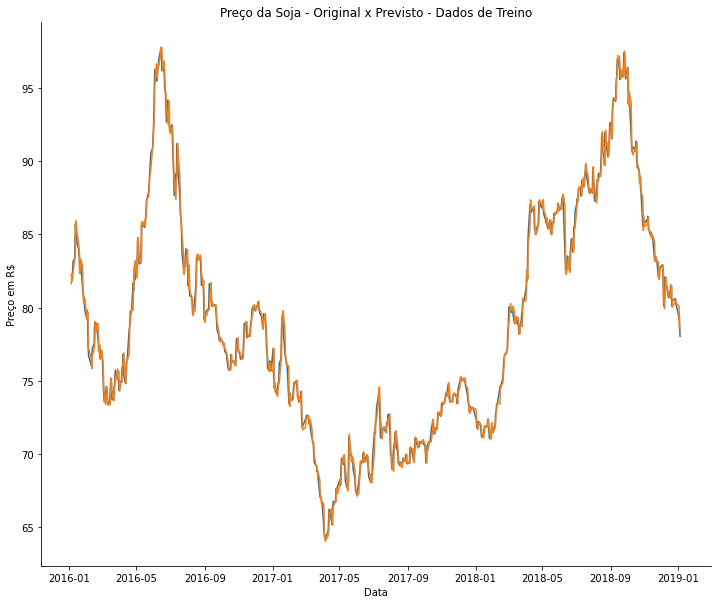

In [56]:
lineplot(modeloV4_avalia_treino.index, modeloV4_avalia_treino['Preco_Original'],
         'Preço da Soja - Original x Previsto - Dados de Treino', 'Preço em R$',
        modeloV4_avalia_treino.index, modeloV4_avalia_treino['Preco_Previsto'])

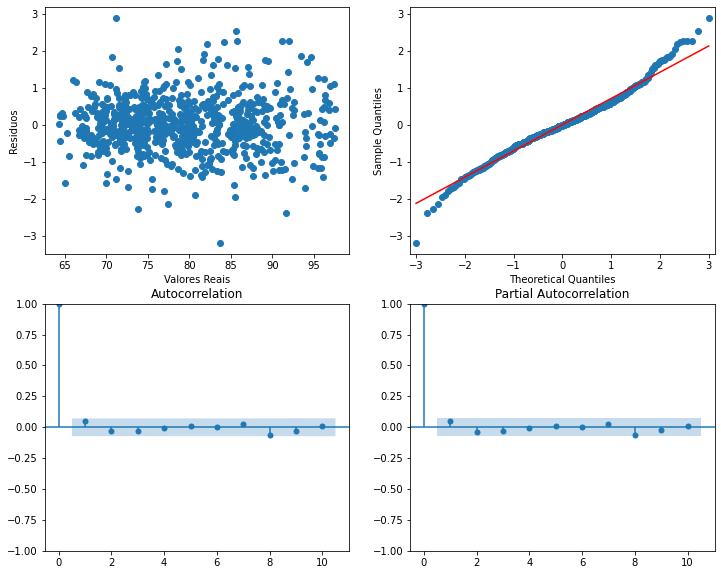

In [57]:
residuosV4_treino = PlotResiduos(modeloV4_avalia_treino)
residuosV4_treino.plot_residuos()

In [58]:
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Observado   No. Observations:                  748
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -805.353
Date:                Thu, 09 Feb 2023   AIC                           1618.706
Time:                        13:11:41   BIC                           1637.176
Sample:                             0   HQIC                          1625.824
                                - 748                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.042     -0.131      0.896      -0.088       0.077
ar.L1          0.8964      0.059     15.196      0.000       0.781       1.012
ma.L1         -0.8326      0.074    -11.308      0.000      -0.977      -0.688
sigma2         0.5043      0.020     25.789      0.000       0.466       0.543
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):                83.89
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.15
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Avaliando em teste

In [59]:
modeloV4_ARMA_teste = teste_diferenciado[['preco_reais']]
modeloV4_ARMA_teste.columns = ['Observado']

coef_ar1 = modelo_v4.arparams.item()
coer_ma1 = modelo_v4.maparams.item()

hist = [modeloV4_ARMA_treino.iloc[i, 0] for i in range(len(modeloV4_ARMA_treino))]
error = [0.0 for i in range(len(modeloV4_ARMA_treino))]

lista_previsao = []

for t in range(len(modeloV4_ARMA_teste)):
    yhat = ((hist[-1] * coef_ar1) + (error[-1] * coer_ma1))
    obs = modeloV4_ARMA_teste.iloc[t, 0]
    lista_previsao.append(yhat)
    hist.append(obs)
    error.append(obs - yhat)

modeloV4_ARMA_teste['Previsto'] = lista_previsao

In [60]:
modeloV4_avalia_teste = retomando_valor_previsto(teste['preco_reais'], modeloV4_ARMA_teste['Previsto'])

avaliacao_teste['ModeloV4_ARIMA11'] = AvaliandoModelos(modeloV4_avalia_teste['Preco_Original'],
                                                      modeloV4_avalia_teste['Preco_Previsto'])

In [61]:
avaliacao_teste

,ModeloV1_MM_5Dias,ModeloV2_MME,ModeloV3_AR1,ModeloV4_ARIMA11
Teste,,,,
MSE,0.489598,0.434751,0.411132,0.415607
RMSE,0.699712,0.659357,0.641195,0.644676
MAE,0.548502,0.522348,0.511781,0.512429
MAPE,0.670886,0.638658,0.626352,0.627299


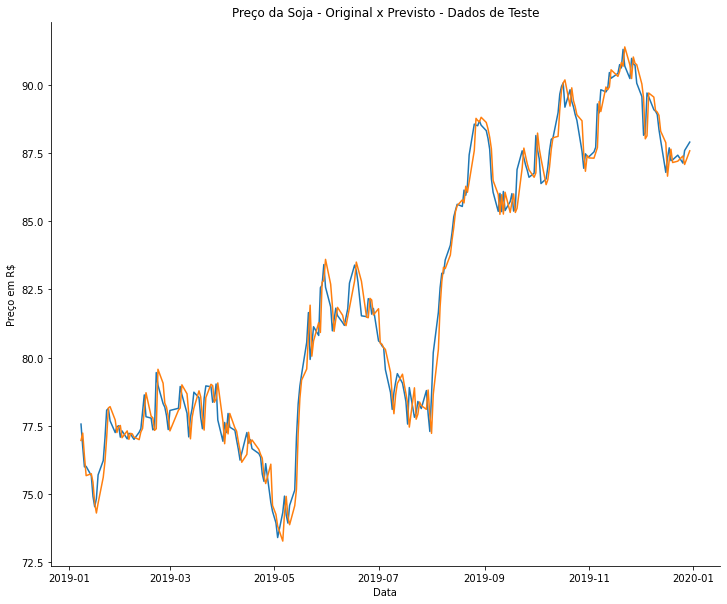

In [62]:
lineplot(modeloV4_avalia_teste.index, modeloV4_avalia_teste['Preco_Original'],
         'Preço da Soja - Original x Previsto - Dados de Teste', 'Preço em R$',
        modeloV4_avalia_teste.index, modeloV4_avalia_teste['Preco_Previsto'])

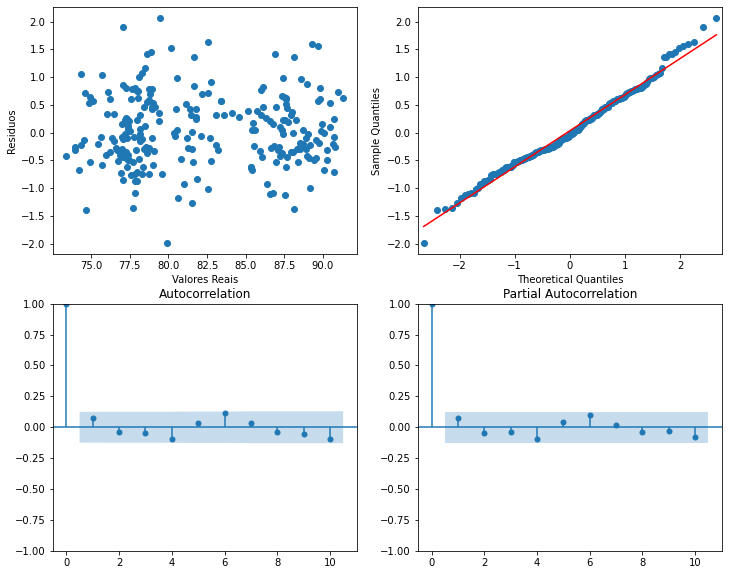

In [63]:
residuosV4_teste = PlotResiduos(modeloV4_avalia_teste)
residuosV4_teste.plot_residuos()

### Modelo 5 - Prophet (Facebook Open-Source Project)

In [64]:
def formatando_dataframe_prophet(dataframe):
    
    df = dataframe.copy()
    # Resetando indice
    df = df.reset_index()
    
    # Alterando nome das colunas
    df.columns = ['ds', 'y']
    return df

In [65]:
# Aplicando formato do pacote Prophet
df_prophet = formatando_dataframe_prophet(df)
df_prophet.head(4)

# Filtrando para posterior comparação
teste_prophet = df_prophet.iloc[749:, :]

In [66]:
# Treinando o modelo
modelo_v5 = Prophet().fit(df_prophet)

# Realizando previsões
future = modelo_v5.make_future_dataframe(periods=365)
forecast = modelo_v5.predict(future)

# Selecionando colunas de interesse
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

13:11:42 - cmdstanpy - INFO - Chain [1] start processing
13:11:42 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
# Colocando em um DataFrame junto com os dados de validação
teste_prophet = teste_prophet.merge(forecast, on = 'ds', how = 'inner')
teste_prophet.head(5)

,ds,y,yhat,yhat_lower,yhat_upper
0,2019-01-07,77.37,79.332330,76.241321,82.386467
1,2019-01-08,77.56,79.374577,76.403916,82.354661
2,2019-01-09,76.72,79.417444,76.457452,82.316042
3,2019-01-10,75.99,79.367976,76.287024,82.303496
4,2019-01-11,76.01,79.286041,76.433480,82.039044


In [68]:
# Avaliando Performance
avaliacao_treino['ModeloV5_Prophet'] = AvaliandoModelos(teste_prophet['y'],
                                                        teste_prophet['yhat'])

avaliacao_treino

,ModeloV1_MM_5Dias,ModeloV2_MME,ModeloV3_AR1,ModeloV4_ARIMA11,ModeloV5_Prophet
Treino,,,,,
MSE,0.391708,0.518593,0.506191,0.504496,3.705551
RMSE,0.625866,0.720134,0.711471,0.710279,1.924981
MAE,0.472164,0.540521,0.524773,0.527527,1.554403
MAPE,0.594312,0.678869,0.658227,0.662445,1.921843


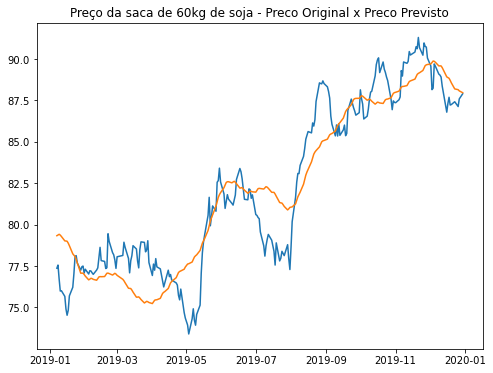

In [69]:
plt.figure(figsize = (8, 6))
plt.plot(teste_prophet['ds'], teste_prophet['y'])
plt.plot(teste_prophet['ds'], teste_prophet['yhat'])
plt.title('Preço da saca de 60kg de soja - Preco Original x Preco Previsto')
plt.ylabel('')
plt.show();

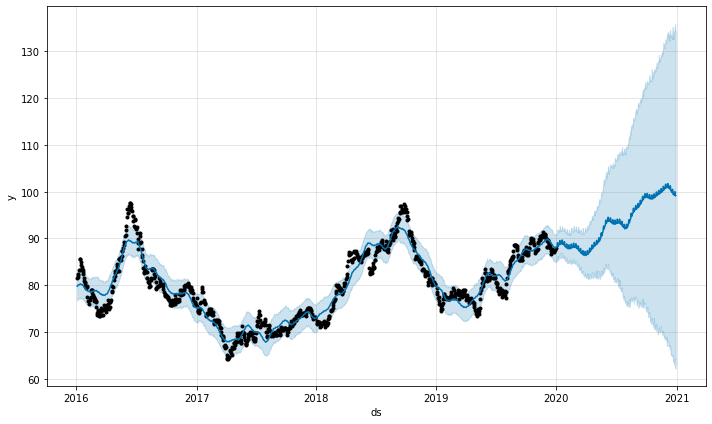

In [70]:
modelo_v5.plot(forecast);

### Avaliando os Resultados

Realizamos a estimação de cinco modelos, incluindo a estimação automática realizada pelo pacote Prophet. O Prophet teve o pior desempenho entre os modelos avaliados. Ele consegue capturar as tendências da série de preços mas com relativo atraso. Além disso, observamos pelo gráfico que a curva com as previsões são muito suaves, de modo que não captura os preços com precisão.

Os modelos restantes apresentam resultados melhores e similares. Os modelos AR e ARIMA apresentam boas propriedades na pós-estimação, com resíduos homocedásticos e independentes, porém falha em apresentar resíduos normalmente distribuídos. Desse modo, poderíamos tentar novas transformações para tentar fazer com que os resíduos apresentem uma distribuição normal.

Nos dados de treino, o modelo de médias móveis de 5 dias apresentou o menor erro quadrado médio (MSE). Porém, validando o modelo nos dados de teste o desempenho foi o pior, embora não esteja tão distante dos demais. Por último, o modelo de médias móveis exponenciais apresentou os resultados mais apropriados. Embora tenha sido o pior resultado em MSE na base de treino, essa medida foi melhor na base de teste ficando melhor que o modelo de médias móveis de 5 dias e muito perto dos modelos AR e ARIMA. Além disso, os valores dos critérios AIC e BIC são melhores no modelo exponencial em relação aos modelos autorregressivos. Considerando, ainda, que os modelos autorregressivos não garantem todas as propriedades desejáveis dos resíduos, concluímos que o modelo que apresentou melhor performance foi o modelo de médias móveis exponencial.

In [71]:
avaliacao_treino

,ModeloV1_MM_5Dias,ModeloV2_MME,ModeloV3_AR1,ModeloV4_ARIMA11,ModeloV5_Prophet
Treino,,,,,
MSE,0.391708,0.518593,0.506191,0.504496,3.705551
RMSE,0.625866,0.720134,0.711471,0.710279,1.924981
MAE,0.472164,0.540521,0.524773,0.527527,1.554403
MAPE,0.594312,0.678869,0.658227,0.662445,1.921843


In [72]:
avaliacao_teste

,ModeloV1_MM_5Dias,ModeloV2_MME,ModeloV3_AR1,ModeloV4_ARIMA11
Teste,,,,
MSE,0.489598,0.434751,0.411132,0.415607
RMSE,0.699712,0.659357,0.641195,0.644676
MAE,0.548502,0.522348,0.511781,0.512429
MAPE,0.670886,0.638658,0.626352,0.627299
